## March Madness Logistic Regression

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
import statsmodels.formula.api as smf

np.random.seed(0)

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('NCAA_Tourney_2002_2021.csv').query("season<2021").reset_index(drop=True)

In [4]:
#list(mm_data.columns)

In [5]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [6]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

In [7]:
[x for x in mm_data.columns if 'name' in x]

['team1_teamname', 'team2_teamname']

In [8]:
mm_data.sort_values('diff_dist')[['team1_teamname','team2_teamname','host']].head()

,team1_teamname,team2_teamname,host
99,Xavier,Hawaii,dallas
555,Villanova,UCLA,philadelphia
112,Pittsburgh,California,pittsburgh
1094,Oregon,Rhode Island,sacramento
651,Florida,Santa Barbara,tampa


## Pythag College Basketball
E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [9]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

## Log Odds
P(W) = (A - A * B) / (A + B - 2*A*B)

In [10]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [11]:
(mm_data
 [['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']]
 .sort_values("team1_log5", ascending=False).head())

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
921,119.7250,Kentucky,2015,Hampton,85.8155,0.978741,0.312700,0.990214
462,116.1109,UCLA,2008,MS Valley St,89.3351,0.953236,0.197019,0.988106
199,117.6452,Duke,2004,Alabama St,89.6445,0.957950,0.246514,0.985842
70,118.5999,Duke,2002,Winthrop,87.7504,0.969660,0.367453,0.982148
25,123.6930,Virginia,2019,Gardner Webb,88.0404,0.980355,0.480146,0.981828


## Seed Diff

In [12]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [13]:
mm_data[['game_id','exp_win1','exp_win2','team2_score',
         'team1_score','diff_dist','team1_log5','team1_id','team2_id','team1_seed','team2_seed','seed_diff']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id,team1_seed,team2_seed,seed_diff
0,2019-1192-1341,0.389061,0.382990,76,82,-648.033425,0.506403,1192,1341,16,16,0
1,2019-1125-1396,0.800207,0.738939,70,81,-307.876634,0.585922,1125,1396,11,11,0
2,2019-1295-1300,0.415885,0.208404,74,78,663.316546,0.730051,1295,1300,16,16,0
3,2019-1113-1385,0.774944,0.721882,65,74,1676.167033,0.570190,1113,1385,11,11,0
4,2019-1278-1257,0.833312,0.913200,76,86,-391.001293,0.322116,1278,1257,10,7,3


## Split Data

In [14]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [15]:
mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)

In [16]:
training_columns = ['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']
mm_data_1 = mm_data.sample(frac=.5, random_state=15)[training_columns]
mm_data_2 = mm_data[~mm_data.index.isin(mm_data_1.index)][training_columns].reset_index(drop=True)
mm_data_1 = mm_data_1.reset_index(drop=True)

In [17]:
mm_data_2['team1_win'] = 0
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data_2['game_id'] = (mm_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
mm_data_2['seed_diff'] = mm_data_2['seed_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff']

In [18]:
mm_train = pd.concat([mm_data_2, mm_data_1]).reset_index(drop=True)

In [19]:
train, test = train_test_split(mm_train, train_size=.7)

In [20]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [21]:
train

,game_id,season,team1_win,exp_win2,exp_win1,team1_score,team2_score,diff_dist,team1_log5,team2_id,team1_id,seed_diff
0,2015-1277-1257,2015,1,0.875558,0.878567,76,70,-292.896059,0.506977,1257,1277,3
1,2014-1444-1393,2014,0,0.892539,0.618266,53,77,336.760336,0.163181,1393,1444,11
2,2009-1345-1449,2009,1,0.905763,0.906818,76,74,-898.733674,0.503104,1449,1345,1
3,2005-1454-1130,2005,1,0.860867,0.784696,83,75,-332.772522,0.370689,1130,1454,8
4,2012-1378-1143,2012,1,0.830810,0.773302,65,54,-1969.242393,0.409913,1143,1378,0
...,...,...,...,...,...,...,...,...,...,...,...,...
820,2014-1163-1246,2014,1,0.884397,0.868820,60,54,1125.588187,0.464019,1246,1163,-1
821,2017-1112-1315,2017,1,0.491105,0.921917,100,82,-468.169585,0.924440,1315,1112,-13
822,2012-1242-1345,2012,1,0.835772,0.939384,63,60,610.554221,0.752792,1345,1242,-8
823,2017-1376-1211,2017,0,0.975337,0.882852,73,77,1238.068898,0.160063,1211,1376,6


## Initial Check

In [22]:
train.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.352795
1    0.611344
Name: team1_log5, dtype: float64

In [23]:
train.groupby('team1_win')['seed_diff'].mean()

team1_win
0    4.477541
1   -3.378109
Name: seed_diff, dtype: float64

In [24]:
train.groupby('team1_win')['diff_dist'].mean()

team1_win
0    256.664905
1   -189.212257
Name: diff_dist, dtype: float64

## Train Logit

In [25]:
logit = LogisticRegression()
logit.fit(X=train[['seed_diff']], y=train['team1_win'])

LogisticRegression()

In [26]:
seed_smlogit = smf.logit("team1_win ~ seed_diff", train).fit()
seed_smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.542809
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  825
Model:                          Logit   Df Residuals:                      823
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Feb 2022   Pseudo R-squ.:                  0.2165
Time:                        08:12:31   Log-Likelihood:                -447.82
converged:                       True   LL-Null:                       -571.58
Covariance Type:            nonrobust   LLR p-value:                 8.999e-56
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0577      0.082      0.704      0.481      -0.103       0.218
seed_diff     -0.1753      0.013    -13.036      0.000      -0.202      -0.149
==============================================================================
"""

In [27]:
test['prob'] = logit.predict_proba(test[['seed_diff']])[:,1]
test['prediction'] = logit.predict(test[['seed_diff']])

In [28]:
test[['game_id','seed_diff','team1_win','prob','prediction']].head()

,game_id,seed_diff,team1_win,prob,prediction
0,2005-1452-1257,3,0,0.385038,0
1,2003-1266-1221,-11,1,0.879322,1
2,2013-1235-1326,8,0,0.206733,0
3,2011-1323-1199,-8,0,0.811551,1
4,2004-1448-1433,-9,1,0.836911,1


In [29]:
test.groupby('team1_win')['prob'].mean()

team1_win
0    0.396588
1    0.610150
Name: prob, dtype: float64

<AxesSubplot:xlabel='prob', ylabel='team1_log5'>

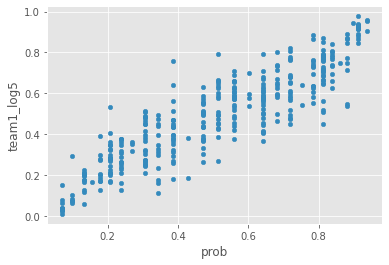

In [30]:
test.plot(kind='scatter', x='prob',y='team1_log5')

In [31]:
confusion_matrix(test['team1_win'], test['prediction'])

array([[108,  58],
       [ 57, 131]])

In [32]:
accuracy_score(test['team1_win'], test['prediction'],)

0.6751412429378532

In [33]:
precision_score(test['team1_win'], test['prediction'])

0.6931216931216931

In [34]:
recall_score(test['team1_win'], test['prediction'])

0.6968085106382979

In [35]:
f1_score(test['team1_win'], test['prediction'])

0.6949602122015914

In [36]:
log_loss(test['team1_win'].values, test['prob'].values, labels=[0,1])

0.5919865982603512

In [37]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

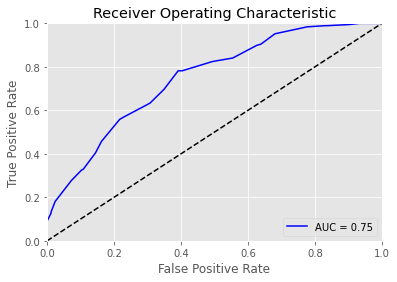

In [38]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [39]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.7467476288131248

## Add Seed Difference & Distance

In [40]:
logit = LogisticRegression()
logit.fit(train[['team1_log5','diff_dist','seed_diff']], train['team1_win'])

LogisticRegression()

In [41]:
smlogit = smf.logit("team1_win ~ team1_log5 + diff_dist + seed_diff", train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.525229
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  825
Model:                          Logit   Df Residuals:                      821
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Feb 2022   Pseudo R-squ.:                  0.2419
Time:                        08:12:32   Log-Likelihood:                -433.31
converged:                       True   LL-Null:                       -571.58
Covariance Type:            nonrobust   LLR p-value:                 1.193e-59
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0251      0.413     -4.906      0.000      -2.834      -1.216
team1_log5     4.1957      0.814      5.151      0.000       2.599       5.792
diff_dist  -4.184e-05   7.05e-05     -0.593      0.553      -0.000    9.64e-05
seed_diff     -0.0590      0.025     -2.346      0.019      -0.108      -0.010
==============================================================================
"""

In [42]:
test['prob'] = logit.predict_proba(test[['team1_log5','diff_dist','seed_diff']])[:,1]
test['prediction'] = logit.predict(test[['team1_log5','diff_dist','seed_diff']])

In [43]:
accuracy_score(test['team1_win'], test['prediction'],)

0.6694915254237288

In [44]:
precision_score(test['team1_win'], test['prediction'])

0.6878306878306878

In [45]:
recall_score(test['team1_win'], test['prediction'])

0.6914893617021277

In [46]:
f1_score(test['team1_win'], test['prediction'])

0.6896551724137931

In [47]:
log_loss(test['team1_win'].values, test['prob'].values)

0.5881939475752272

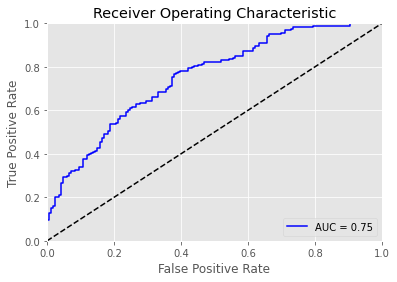

In [48]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [49]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.7518584978210716

## Create Example Submission

In [50]:
example_submission = pd.read_csv('NCAA_Tourney_2002_2021.csv').query("season==2019").reset_index(drop=True)

In [51]:
example_submission['seed_diff'] = example_submission['team1_seed'] - example_submission['team2_seed']

In [52]:
example_submission['prob'] = seed_smlogit.predict(example_submission['seed_diff'])

In [53]:
example_submission[['game_id','prob']].head()

,game_id,prob
0,2019-1192-1341,0.514424
1,2019-1125-1396,0.514424
2,2019-1295-1300,0.514424
3,2019-1113-1385,0.514424
4,2019-1278-1257,0.385021


In [54]:
example_submission[['game_id','prob']].shape

(67, 2)

In [55]:
example_submission[['game_id','prob']].to_csv("trp_example_submission.csv", index=False)